### New Generation Scheme 

Here's a new generation scheme. The main idea is to assume that the proportion of left to right winged individuals is constant. 

In [1]:
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from scipy.stats import beta
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import make_scorer, log_loss, f1_score, accuracy_score

In [2]:
MAIN_PATH     = f'/mnt/storage/jcheigh/fictitious-prediction'
SRC_PATH      = f'{MAIN_PATH}/src'
IMAGE_PATH    = f'{MAIN_PATH}/images'            
DATA_PATH     = f"{MAIN_PATH}/data"
CSV_FPATH     = f'{DATA_PATH}/results.csv'

In [3]:
pop_size = 1000 # population size per timestep
lex_size = 10 # number of {right, left, neutral} words
speech_len = 15 # number of words per speech
timesteps  = 1500 # num timesteps
left_prop = .5 # expected prop of popn to be left 
alpha_p    = 3 # beta params for sampling rho
beta_p     = 3
epsilon    = 0.05 # exp prop of neutral words per speech
vocab_size = 3 * lex_size  # vocab size
num_folds  = 5 # folds per training
scoring    = 'neg_log_loss' # scoring method 

### Population Polarization Generation

For each timestep, we begin by sampling a global polarization $\rho \in [.5, 1]$. If $\rho \approx .5$ then there is very low polarization, i.e. the speeches by right/left winged individuals is very similar. If $\rho \approx 1$ then there's very high polarization. 

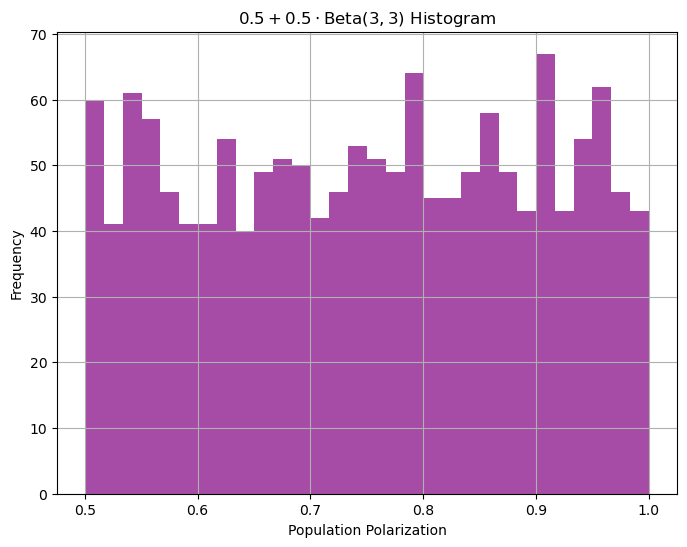

In [4]:
def get_rhos(a=alpha_p, b=beta_p, timesteps=timesteps):
    """
    generates rhos, i.e. a vector R where R[i] is the pop polarization at
    timestep i.
    """
    return np.random.uniform(0.5, 1, size=timesteps)
    #return .5 + .5 * beta.rvs(a, b, size=timesteps)

rhos = get_rhos()

plt.figure(figsize=(8, 6))
plt.hist(rhos, bins=30, color='purple', alpha=0.7)
plt.grid(True)
plt.title(r"$\mathrm{Unif}(5, .95)$ Histogram")
plt.xlabel("Population Polarization")
plt.ylabel("Frequency")
plt.show()

Eventually, we will sample individual polarizations $u_i$ from a Beta distribution. The Beta distribution has two parameters ($\alpha, \beta$). Here we set the variance $\sigma_t$ as a direct function of $\rho_t$, allowing us to solve the system of equations to obtain $\alpha_t, \beta_t$. By playing around in Desmos I came up with this function. Basically I just look at $\rho \in \{.6, .7, .8, .9\}$ and found corresponding $\sigma$ that made the distribution ``look nice''. From here I plotted and then fit a degree 3 polynomial. 

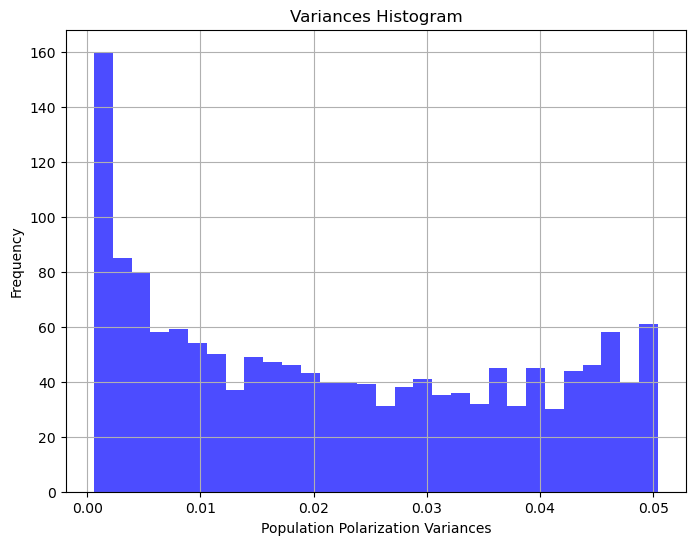

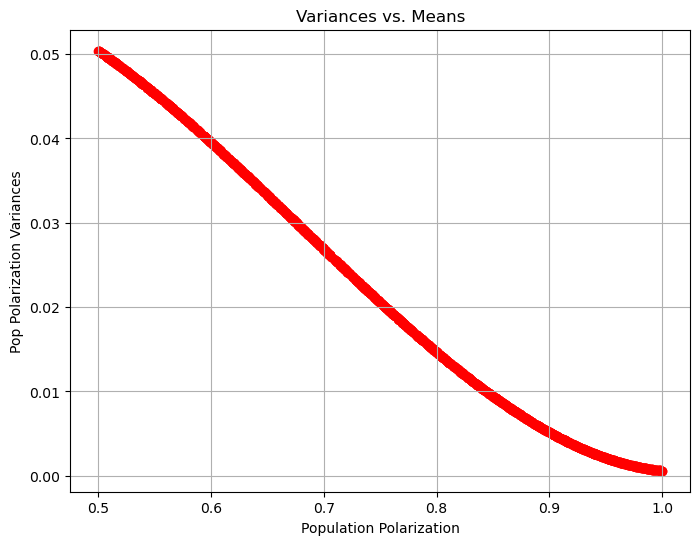

In [5]:
def get_variances(rhos):
    return (.373 * (rhos ** 3) - .76 * (rhos ** 2) + .3876 * rhos)

sigmas = get_variances(rhos)

plt.figure(figsize=(8, 6))
plt.hist(sigmas, bins=30, color='blue', alpha=0.7)
plt.grid(True)
plt.title(r"Variances Histogram")
plt.xlabel("Population Polarization Variances")
plt.ylabel("Frequency")
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(rhos, sigmas, color='r')
plt.grid(True)
plt.title(r"Variances vs. Means")
plt.xlabel("Population Polarization")
plt.ylabel("Pop Polarization Variances")
plt.show()

Given $\rho, \sigma$, we theoretically should be able to solve for $\alpha, \beta$. Specificially, we want a distribution $\mathrm{Beta}(\alpha, \beta)$ such that the expectation is $\rho$ and the variance is $\sigma$. We get 
\begin{align*}
   \rho &= \frac{\alpha}{\alpha + \beta}  \\
    \sigma &= \frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}
\end{align*}

After some algebra we get
\begin{align*}
    \alpha &= \rho \left(\frac{\rho (1-\rho)}{\sigma} - 1\right) \\
    \beta &= (1-\rho) \left(\frac{\rho (1-\rho)}{\sigma} - 1\right),
\end{align*}
which works under the condition that $\frac{\rho(1-\rho)}{\sigma} > 1$. 

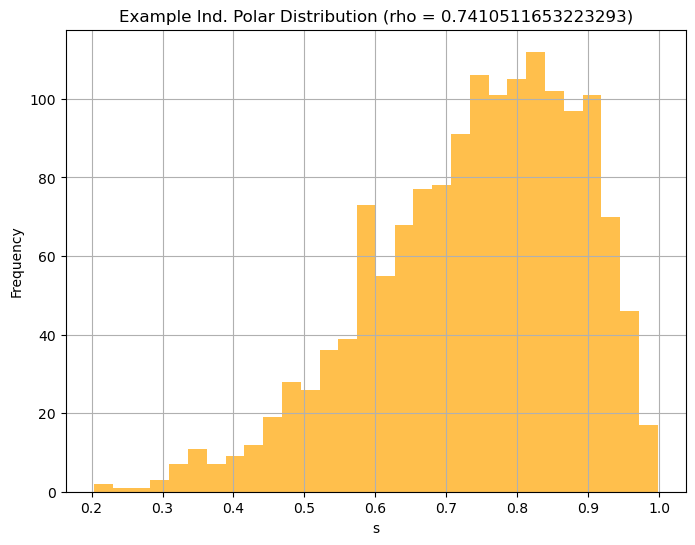

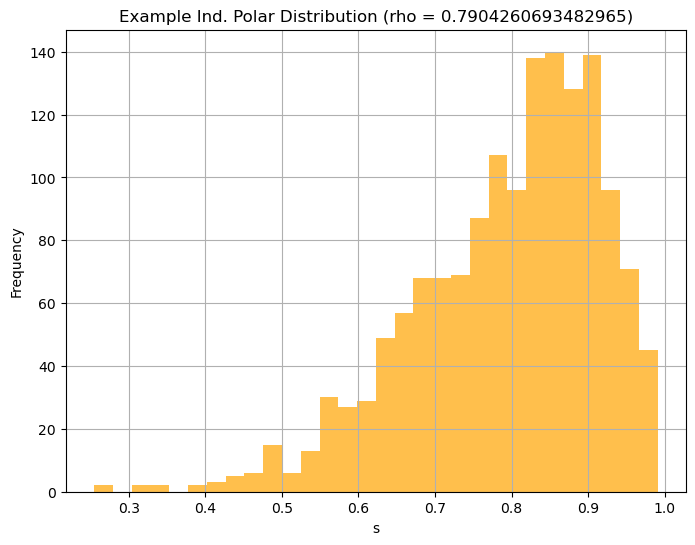

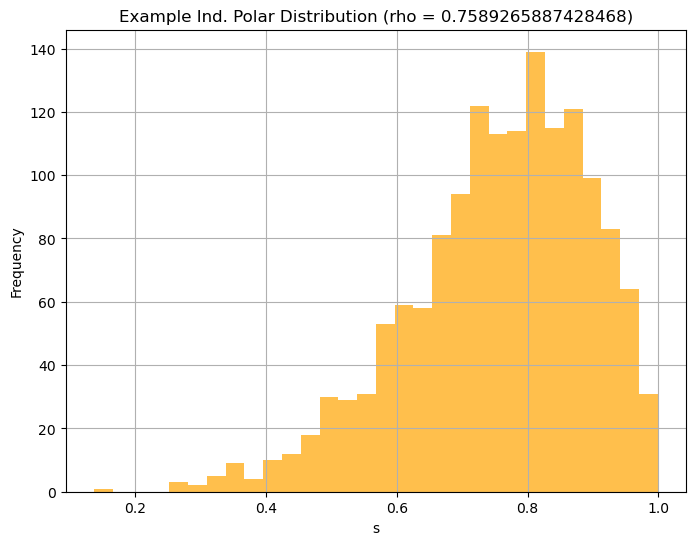

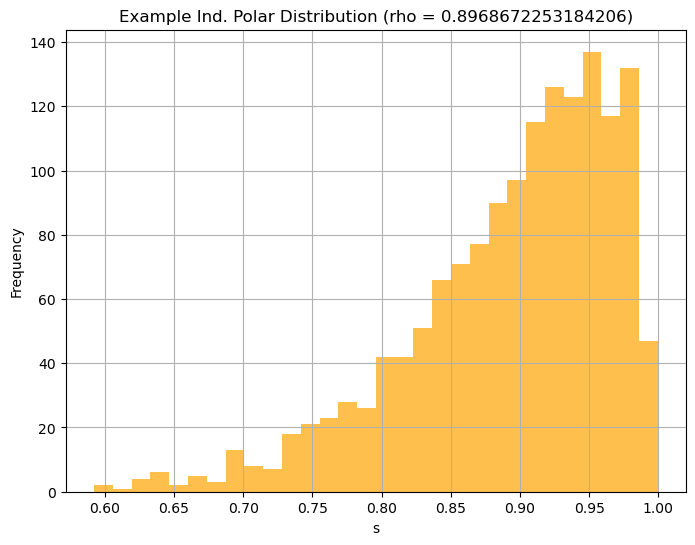

In [6]:
def get_beta_params(rhos):
    sigmas = get_variances(rhos)
    alphas = rhos * ((rhos * (1 - rhos))/sigmas - 1)
    betas  = (1 - rhos) * ((rhos * (1 - rhos))/sigmas - 1)
    return alphas, betas 

alphas, betas = get_beta_params(rhos)

for i in range(4):
    ex1 = (alphas[i], betas[i])

    plt.figure(figsize=(8, 6))
    vals = beta.rvs(ex1[0], ex1[1], size=timesteps) 
    plt.hist(vals, bins=30, color='orange', alpha=0.7)
    plt.grid(True)
    plt.title(f"Example Ind. Polar Distribution (rho = {round(rhos[i], 3)})")
    plt.xlabel("s")
    plt.ylabel("Frequency")
    plt.show()
    

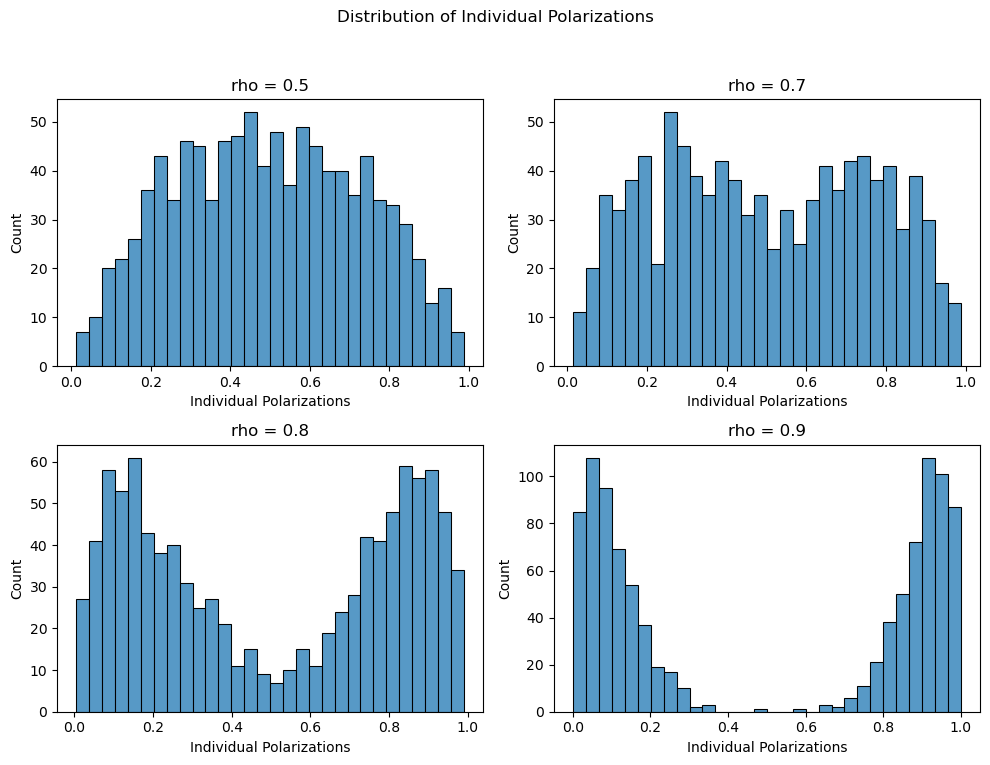

In [7]:
test_rhos   = np.array([.5, .7, .8, .9])
test_alphas, test_betas = get_beta_params(test_rhos)

data = []
for a, b in list(zip(test_alphas, test_betas)):
    n_left = int(left_prop * pop_size)
    ind_polar = np.concatenate((beta.rvs(b, a, size=n_left),beta.rvs(a, b, size=pop_size - n_left)))
    np.random.shuffle(ind_polar)
    data.append(ind_polar)

plt.figure(figsize=(10, 8))
plt.suptitle(f'Distribution of Individual Polarizations')
for i in range(4):
    plt.subplot(2, 2, i+1) 
    sns.histplot(data[i], bins=30, kde=False)
    plt.title(f'rho = {test_rhos[i]}')
    plt.xlabel('Individual Polarizations')
    plt.ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()

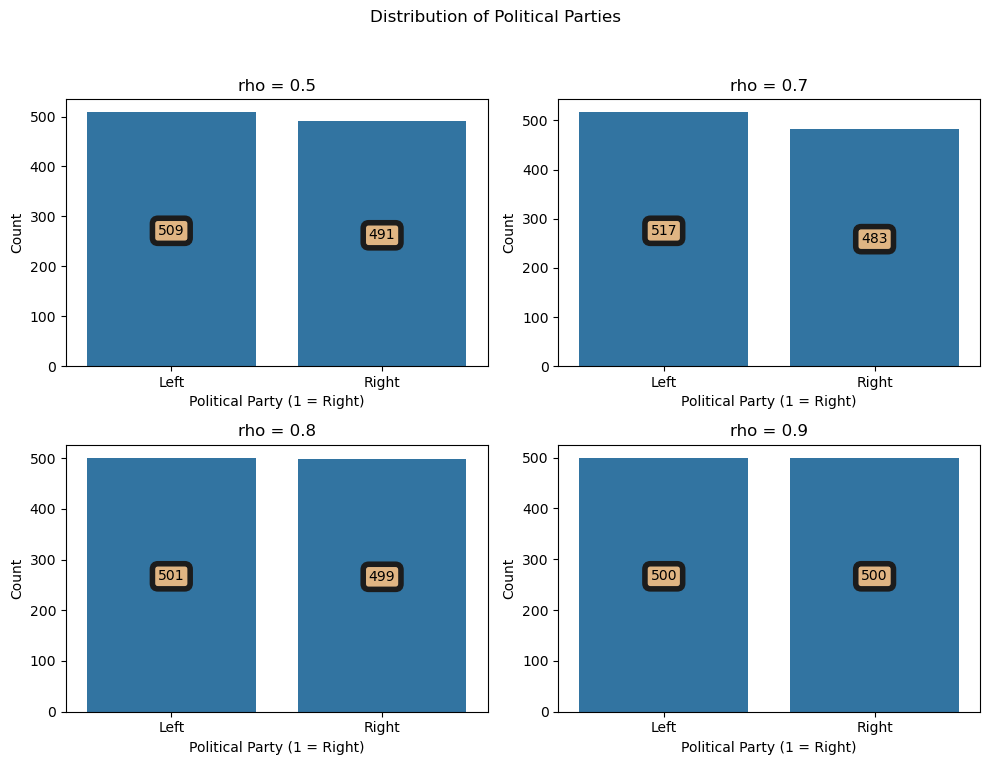

In [8]:
y_data = [(polar >= 0.5).astype(int) for polar in data]
y_data = [['Right' if y == 1 else 'Left' for y in polar] for polar in y_data]

plt.figure(figsize=(10, 8))
plt.suptitle(f'Distribution of Political Parties')
for i in range(4):
    plt.subplot(2, 2, i+1) 
    p = sns.countplot(x = y_data[i], order = sorted(set(y_data[i])))

    for container in p.containers: 
        p.bar_label(container, label_type = "center", padding = 6, size = 10, color = "black", 
                bbox={"boxstyle": "round", "pad": 0.4,"facecolor": "#e0b583", 
                        "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})

    plt.title(f'rho = {test_rhos[i]}')
    plt.xlabel('Political Party (1 = Right)')
    plt.ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()

In [9]:
polar_map = {}
for i, (a,b) in enumerate(list(zip(test_alphas, test_betas))):
    test_polars = beta.rvs(a, b, size=4)
    rho = test_rhos[i]
    polar_map[rho] = test_polars
    print(f'rho = {test_rhos[i]} -> polars = {[round(p, 2) for p in test_polars]}')

rho = 0.5 -> polars = [0.45, 0.75, 0.35, 0.12]
rho = 0.7 -> polars = [0.53, 0.63, 0.47, 0.47]
rho = 0.8 -> polars = [0.97, 0.7, 0.42, 0.93]
rho = 0.9 -> polars = [0.96, 0.97, 0.92, 0.87]


In [12]:
def get_phi(rho, u, eps=epsilon, L=lex_size):
    left_prob = (1 - eps) * (1 - u) / L 
    right_prob = (1 - eps) * u / L
    neutral_prob = (eps / L)
    phi = [left_prob] * L + [right_prob] * L + [neutral_prob] * L
    return phi

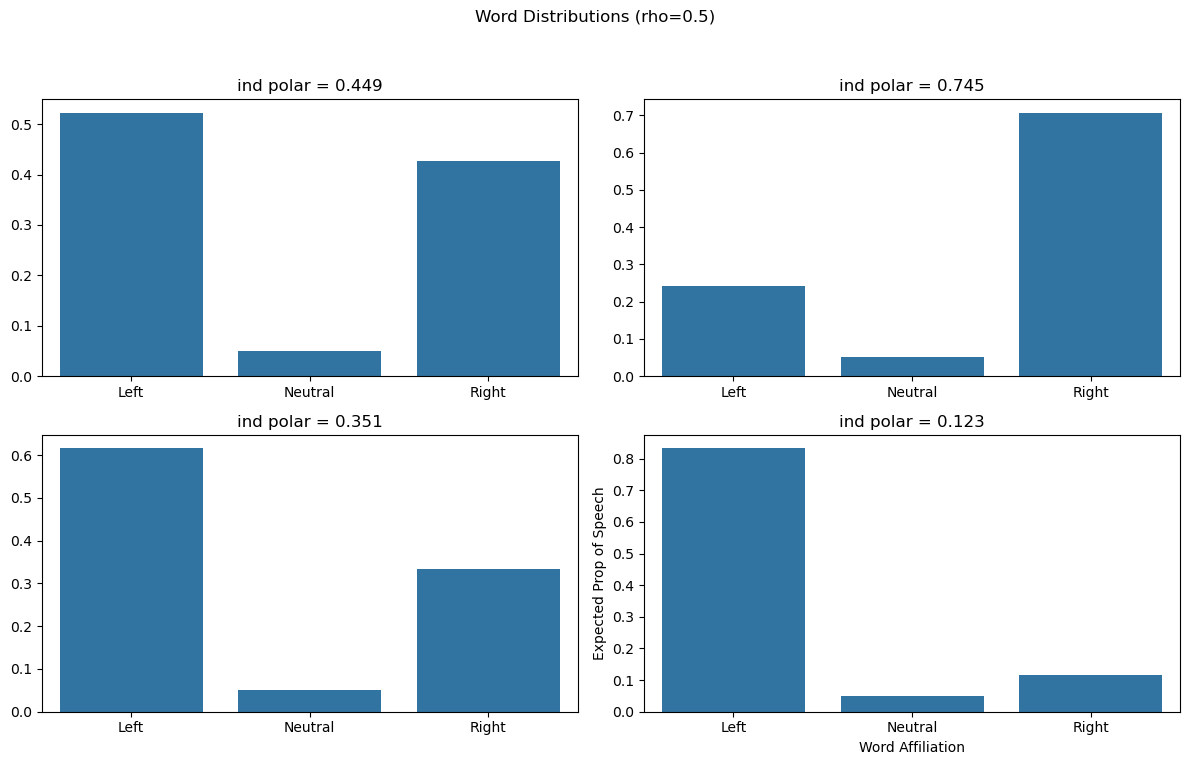

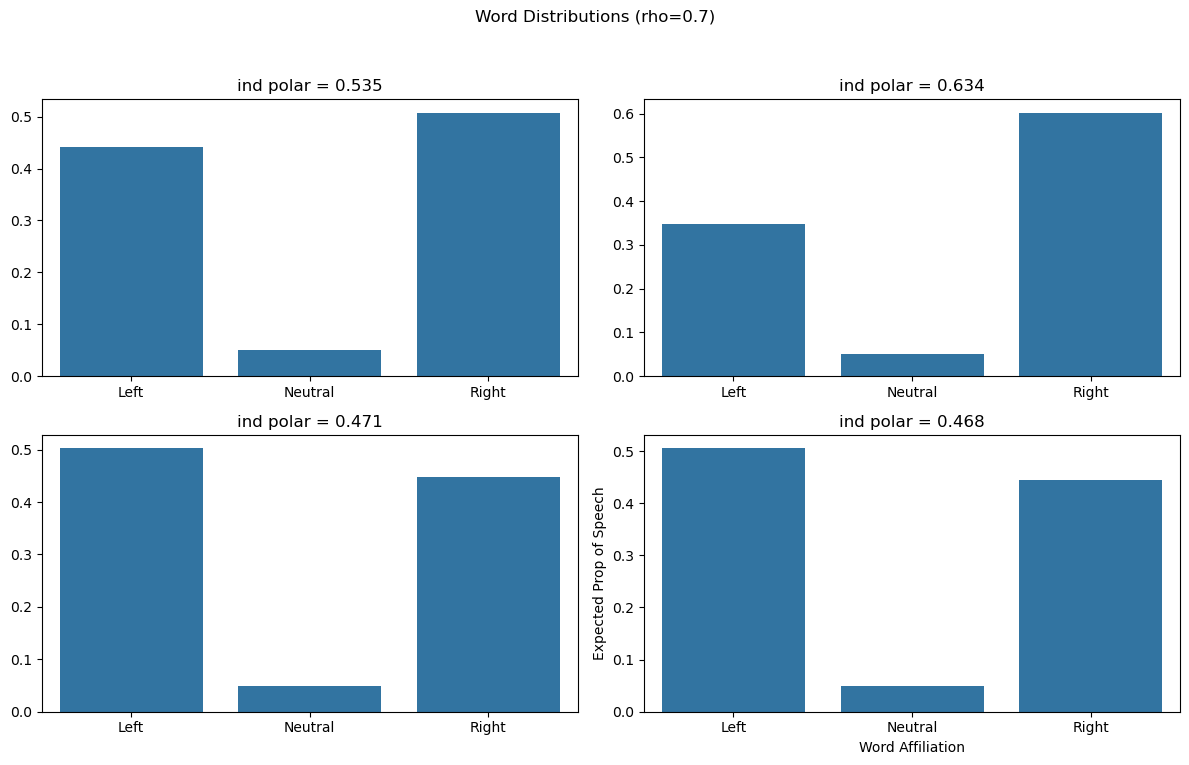

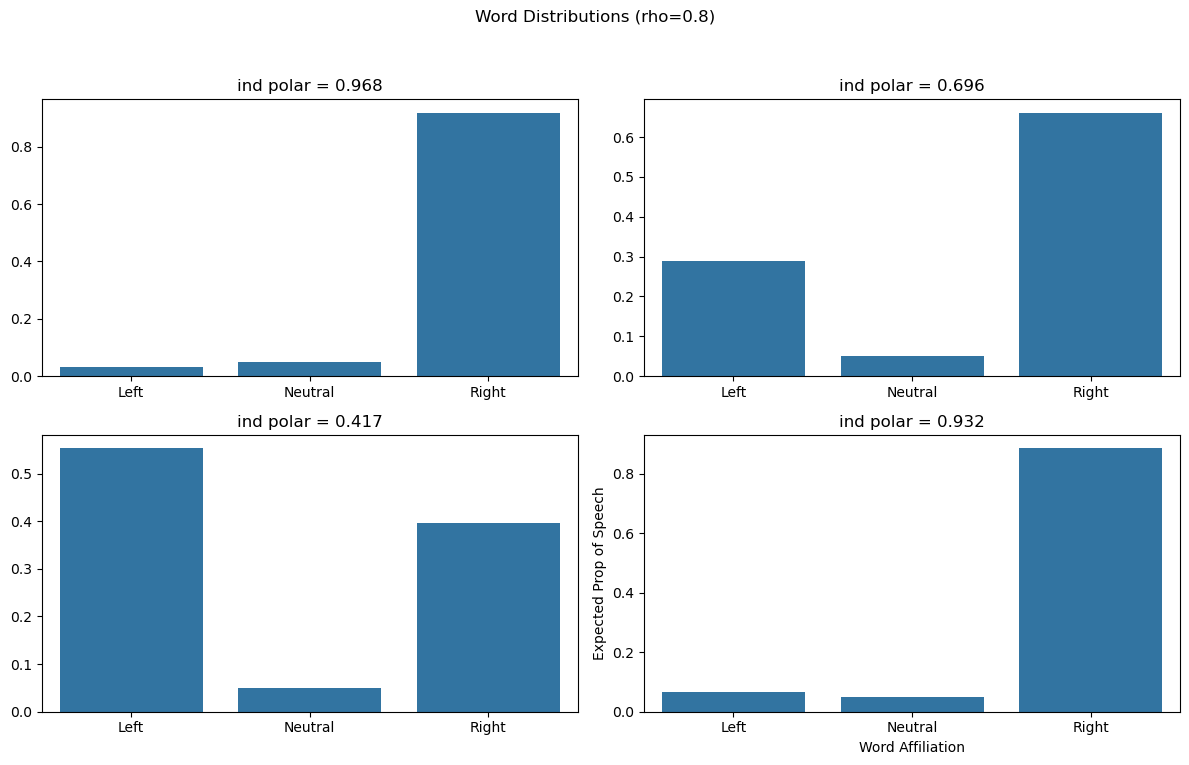

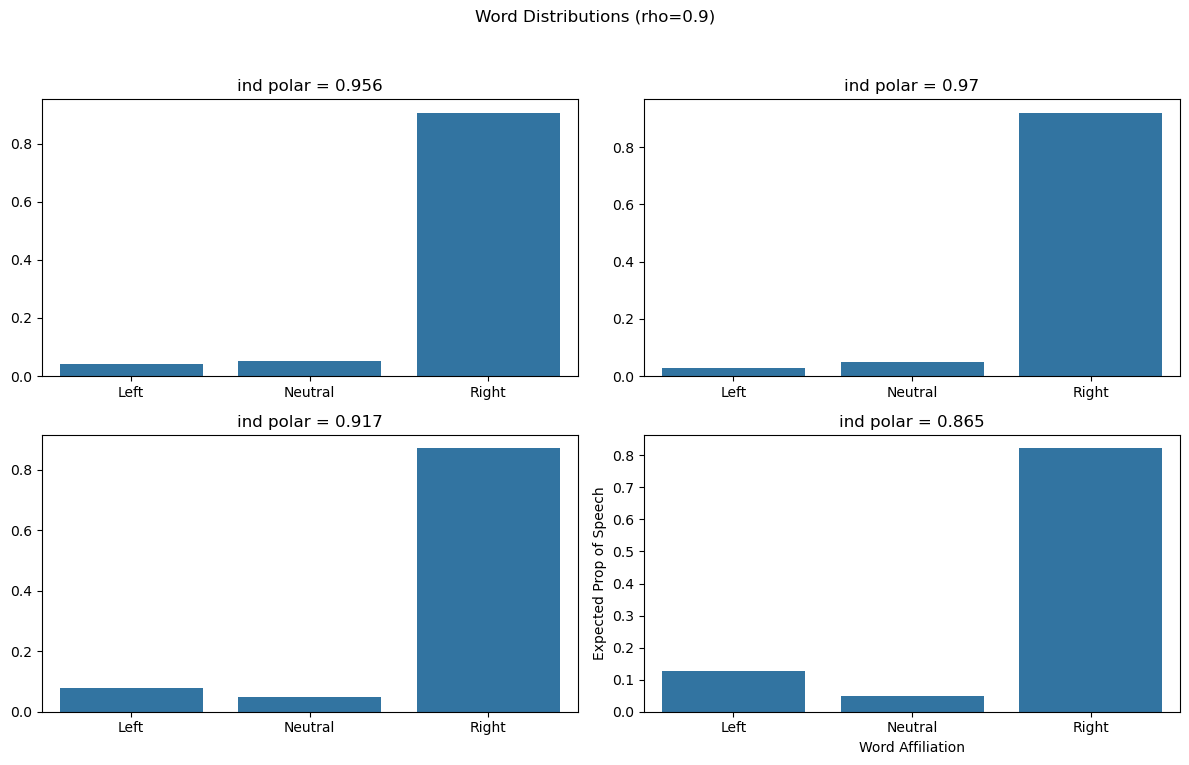

In [13]:
for rho, us in polar_map.items():
    fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 
    fig.suptitle(f"Word Distributions (rho={rho})")

    for i, u in enumerate(us):
        data = get_phi(rho, u)
        count_data = {
            'Left'   : lex_size * data[0],
            'Neutral': lex_size * data[-1],
            'Right'  : lex_size * data[lex_size]
        }
        categories = list(count_data.keys())
        counts = list(count_data.values())
        ax = plt.subplot(2, 2, i+1) 
        sns.barplot(x=categories, y=counts, ax=ax)
        ax.set_title(f'ind polar = {round(u, 3)}')

    plt.xlabel("Word Affiliation") 
    plt.ylabel("Expected Prop of Speech") 
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
def generate(timesteps):
    rhos = get_rhos(timesteps=timesteps)
    alphas, betas = get_beta_params(rhos)
    n_left = int(left_prop * pop_size)

In [26]:
def generate(timesteps=timesteps):
    rhos = np.random.uniform(0.5, .95, size=timesteps)
    sigmas = (.373 * (rhos ** 3) - .76 * (rhos ** 2) + .3876 * rhos)
    alphas = rhos * ((rhos * (1 - rhos)) / sigmas - 1)
    betas = (1 - rhos) * ((rhos * (1 - rhos)) / sigmas - 1)
    n_left = int(left_prop * pop_size)
    n_right = pop_size - n_left

    polar_left = np.array([beta.rvs(alphas[t], betas[t], size=n_left) for t in range(timesteps)])
    polar_right = np.array([beta.rvs(betas[t], alphas[t], size=n_right) for t in range(timesteps)])
    polar = np.concatenate([polar_left, polar_right], axis=1)
    
    np.random.shuffle(polar.T)  #
    y = (polar >= 0.5).astype(int)

    polar_expanded = polar[:, :, np.newaxis]
    left_prob = (1 - epsilon) * (1 - polar_expanded) / lex_size
    right_prob = (1 - epsilon) * polar_expanded / lex_size
    neutral_prob = np.full(left_prob.shape, epsilon / lex_size)

    phi = np.concatenate([np.repeat(left_prob, lex_size, axis=2),
                          np.repeat(right_prob, lex_size, axis=2),
                          np.repeat(neutral_prob, lex_size, axis=2)], axis=2)

    X = np.array([[np.random.multinomial(speech_len, phi[t, i, :])
                   for i in range(pop_size)] for t in range(timesteps)])

    data = [(X[t], y[t]) for t in range(timesteps)]

    return data, rhos


In [34]:
data, rhos = generate()

In [38]:
small_rho = rhos[2] # rho = .604
large_rho = rhos[7] # rho = .848

In [39]:
Xs, ys = data[2]
Xl, yl = data[7]

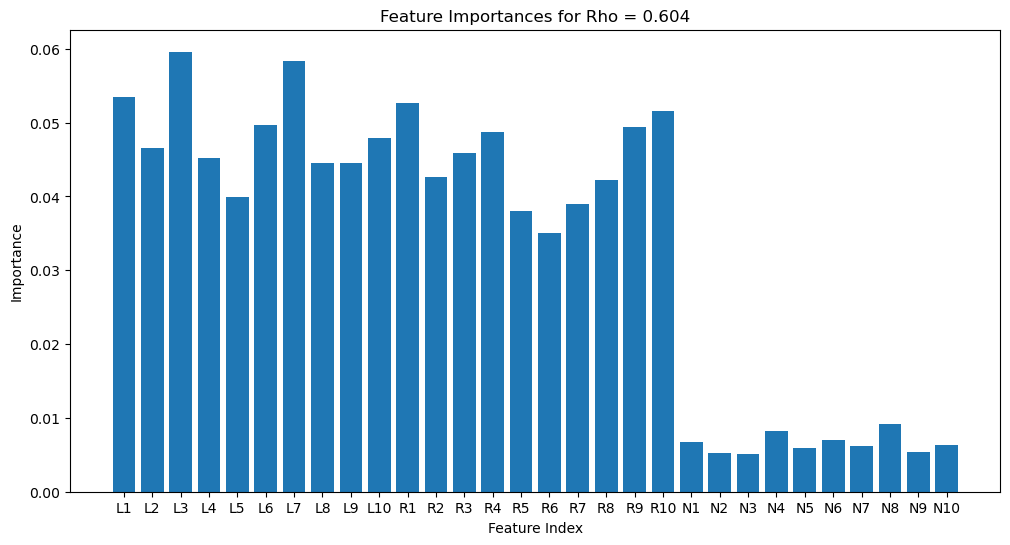

In [45]:
clf         = RandomForestClassifier()
grid_search = GridSearchCV(estimator=clf, param_grid={}, cv=num_folds, scoring=scoring)
grid_search.fit(Xs, ys)
best_clf    = grid_search.best_estimator_

def get_feature(i):
    if i >= 20:
        return f'N{i-19}'
    elif i <= 9:
        return f'L{i+1}'
    return f"R{i-9}"

plt.figure(figsize=(12, 6))
plt.title(f"Feature Importances for Rho = {round(small_rho, 3)}")
plt.bar([get_feature(i) for i in range(Xs.shape[1])], best_clf.feature_importances_)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.xticks(range(Xs.shape[1]))
plt.show()

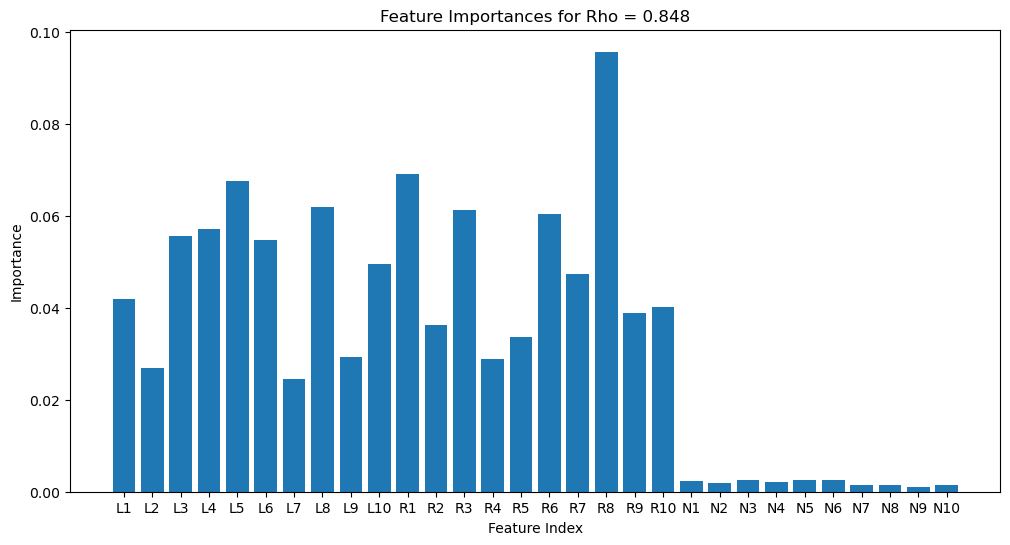

In [44]:
clf         = RandomForestClassifier()
grid_search = GridSearchCV(estimator=clf, param_grid={}, cv=num_folds, scoring=scoring)
grid_search.fit(Xl, yl)
best_clf    = grid_search.best_estimator_

plt.figure(figsize=(12, 6))
plt.title(f"Feature Importances for Rho = {round(large_rho, 3)}")
plt.bar([get_feature(i) for i in range(Xl.shape[1])], best_clf.feature_importances_)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.xticks(range(Xl.shape[1]))
plt.show()

In [59]:
def train(data, rhos, model=RandomForestClassifier(), calibrated=True, cal_method='sigmoid', scoring=scoring):
    score_map = {}

    scoring_functions = {
        'neg_log_loss' : make_scorer(log_loss, greater_is_better=False, needs_proba=True),
        'f1'           : 'f1',
        'accuracy'     : 'accuracy'
        }

    for i, (X, y) in tqdm(enumerate(data)):
        try:
            if not calibrated:
                grid_search = GridSearchCV(model, param_grid={}, cv=num_folds, scoring=scoring)
                grid_search.fit(X, y)
                best_score = grid_search.best_score_
            else:
                cv_splitter = StratifiedKFold(n_splits=num_folds, shuffle=True)
                calibrated_model = CalibratedClassifierCV(estimator=model, method=cal_method, cv=cv_splitter)
                calibrated_model.fit(X, y)

                score_func = scoring_functions.get(scoring, 'accuracy') 
                scores = cross_val_score(calibrated_model, X, y, cv=cv_splitter, scoring=score_func)
                best_score = scores.mean()

            score_map[rhos[i]] = best_score

        except Exception as e:
            pass

    return score_map


In [47]:
data, rhos = generate(100)
score_map  = train(data, rhos)

100it [08:51,  5.31s/it]


In [51]:
cscore_map = train(data, rhos, calibrated=True)

100it [08:14,  4.94s/it]


In [55]:
iscore_map = train(data, rhos, calibrated=True, cal_method='isotonic')

100it [07:20,  4.41s/it]


In [60]:
ascore_map = train(data, rhos, scoring='accuracy')

100it [07:11,  4.32s/it]


In [61]:
def plot(score_map, cscore_map, iscore_map, scoring=scoring):
    scoring_map = {"accuracy": "Accuracy", "neg_log_loss": "Negative Log Loss", "f1": "F1 Score"}
    y_label = scoring_map.get(scoring, scoring)  
    x_label = "Polarization"
    plot_title = f"{y_label} vs. {x_label}"
    
    plt.figure(figsize=(10,6))
    sns.set(style="whitegrid")
    
    sns.scatterplot(x=list(score_map.keys()), y=list(score_map.values()), color="blue", label="Uncalibrated")
    #sns.scatterplot(x=list(cscore_map.keys()), y=list(cscore_map.values()), color="green", label="Platt Scaling")
    #sns.scatterplot(x=list(iscore_map.keys()), y=list(iscore_map.values()), color="red", label="Isotonic Calibration")
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend(title="Calibration Method")
    plt.show()


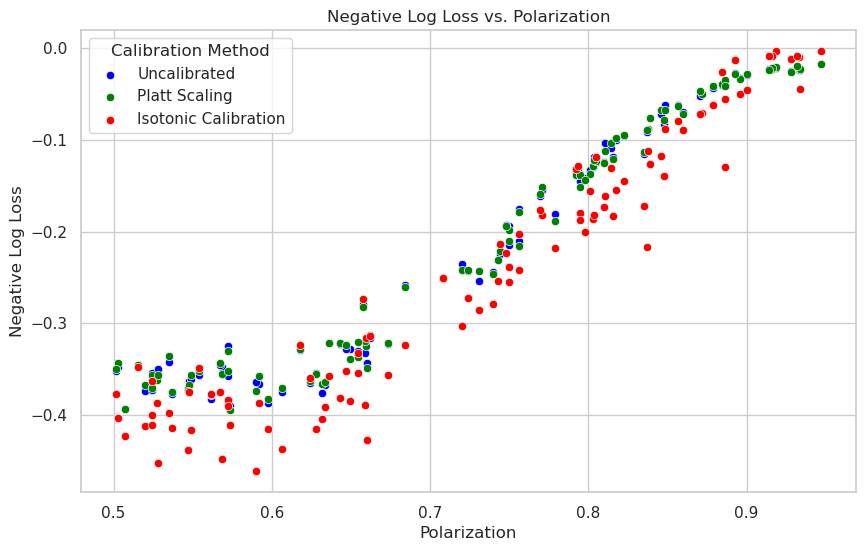

In [57]:
plot(score_map, cscore_map, iscore_map)

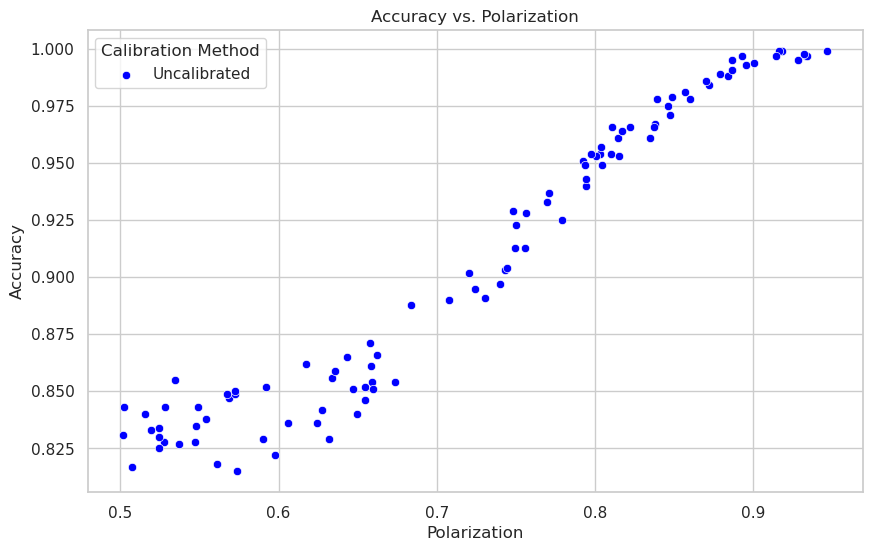

In [63]:
plot(ascore_map,1,1, scoring='accuracy')